### import libraries

In [1]:
#for sql
!pip install sqldf
import sqldf
import pandas as pd
#for viz
import seaborn as sns
import matplotlib.pyplot as plt

# ***A History of F1: The Fastest Sport in the world***

Since its inception in 1950, Formula 1, often referred to as F1, has been celebrated as the pinnacle of motor racing. Emerging from a mix of amateur racing enthusiasts and automotive manufacturers, the sport has evolved and become renowned for being at the forefront of innovation and technology. It inspires millions of race fans worldwide as teams and drivers compete against each other and the clock, striving for the ultimate honor of being crowned world champions.

As a fan of F-1 since the late 90's, I'm going to dig into the data and see what insights I can gather and get a look at how the sport I love so dearly has evolved and also paint a picture for anyone curious to see what F1 is all about.

The dataset used spans the years 1950-1975 and can be found here:
[dataset](https://https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020?resource=download#)

## ***The Basics***

Let's start with the basics:

F-1 is comprised of teams who build the cars and employ drivers who race them. Although a team sport, it's usually the drivers who get all the attention. They are the most visible part of the team and in teams that are fielded by manufacturers, they also become the de-fato face of the brand. They also risk their lives since motor-racing is inherently a dangerous sport.

So, let's see what we can find out about the various teams and drivers who have a part of F1 in the past 75 years.

### ***Teams***

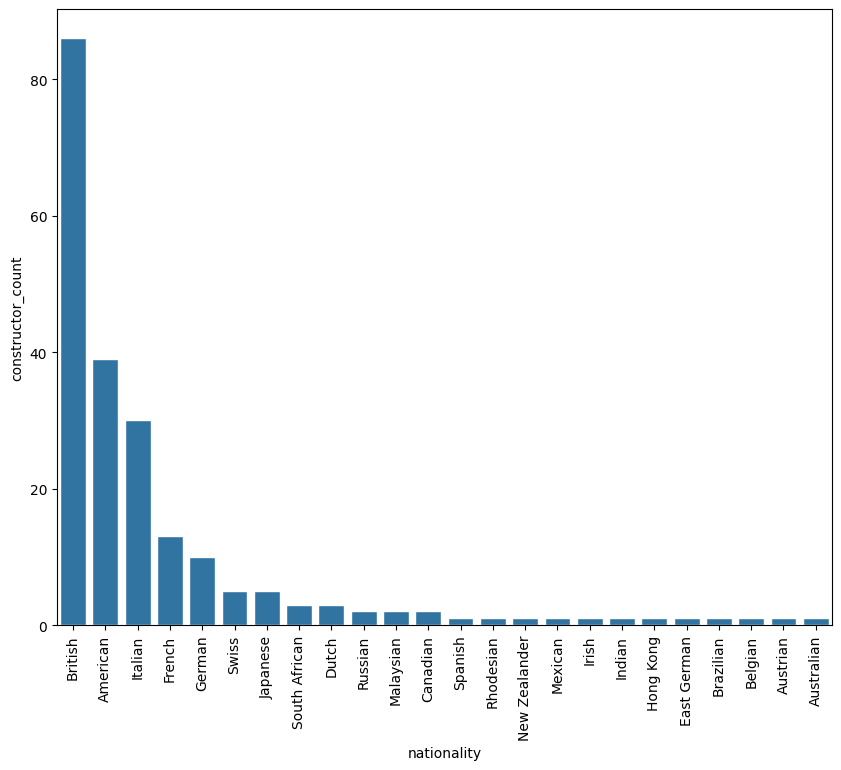

In [2]:
#grouping constructors and nationality
#read the csv file
constructors = pd.read_csv('/content/constructors.csv')

query = """
SELECT nationality,
       COUNT(*) AS constructor_count
FROM constructors
GROUP BY nationality
ORDER BY constructor_count DESC
"""
#convert to df to plot
result = sqldf.run(query)

#plot

#set figure size
fig,ax=plt.subplots(figsize=(10,8))
#set background color for the bar chart
sns.set_style('darkgrid')
#plot bar chart
ax.grid(False)
sns.barplot(data=result, x='nationality', y='constructor_count',ax=ax);
#rotate the labels for visibility
plt.xticks(rotation=90);

F1 is predominantly based in Europe with the UK dubbed as the Silicon Valley of the sport. Even most current teams have their racing HQ's and facilities in the UK. Hence, it is not unsurprising to see that most F1 teams are European and a majority overwhelmingly English.

### ***Type of Teams***

Delving into team histories is very convoluted because of the ways teams grow and evolve. F1 being very complex and expensive meant most teams did not last very long as they ran out of money. Teams also get bought-out or taken over by other wealthy individuals, consortiums, OEM's etc. and consequently get rebranded.


For example: the current Mercedes-AMG team traces it's lineage back to the 1980's when it was first owned and run by Ken Tyrrell before being bought by British American Tobacco who raced as British American Racing, then taken over by the Japanese behemoth Honda before being rescued from insolvency by famed F1 race engineer, Ross Brawn as Brawn GP in the wake of the 2008 economic crisis.

Independent teams also often tied-up with OEM's by way of sponsorship or exhange of technology. Such tie-ups led to rebranding of the team to reflect the new partnership. For example: Team Mclaren was rebranded to McLaren-Honda when they sourced their engines from Honda. They are now called McLaren-Mercedes as they now run Mercedes engines. This is also a way
team branding evolves.

Let's look at the composition of teams across the sports history:

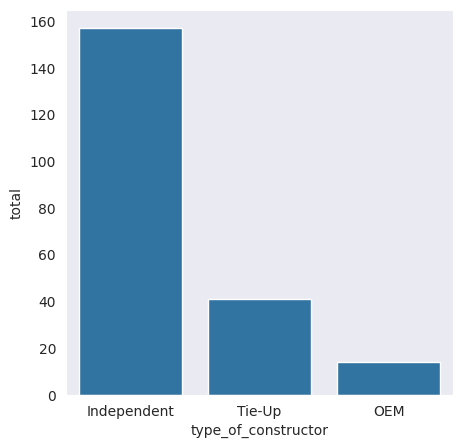

In [3]:
#team composition

query="""
SELECT type AS type_of_constructor,
       count(*) AS total
FROM constructors
GROUP BY type
ORDER BY total DESC
"""
result = sqldf.run(query)

#plot
#set figure size
fig,ax=plt.subplots(figsize=(5,5))
#set background color for the bar chart
sns.set_style('darkgrid')
ax.grid(False)
#plot bar chart
sns.barplot(data=result, x='type_of_constructor', y='total');
#rotate the labels for visibility
# plt.xticks(rotation=90);

### ***Most successful Team of all time***

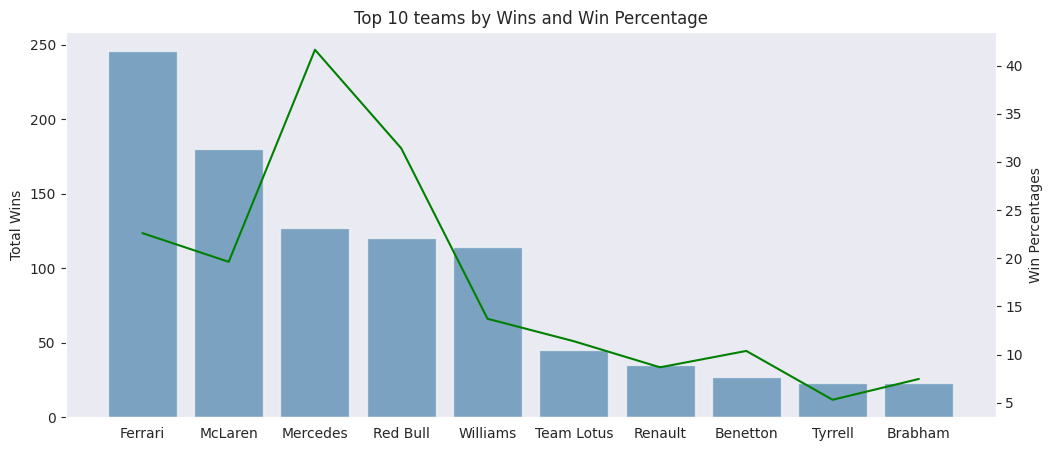

In [4]:
#combining results and races
#using DISTINCT to get the right number of races

results = pd.read_csv('/content/results.csv')
races = pd.read_csv('/content/races.csv')

query = """

SELECT
        constructors.constructorId,
        constructors.name,
        COUNT(DISTINCT(races.raceId)) AS total_races,
        COUNT(CASE WHEN results.positionOrder = 1 THEN 1 END) AS total_wins,
        ROUND(COUNT(CASE WHEN results.positionOrder = 1 THEN 1 END) * 100.0 / COUNT(DISTINCT(races.raceId)),2) AS win_percentage,
        COUNT(CASE WHEN results.positionOrder = 2 THEN 1 END) AS total_second_place_finishes,
        COUNT(CASE WHEN results.positionOrder = 3 THEN 1 END) AS total_third_place_finishes
FROM constructors
JOIN results ON
     constructors.constructorId = results.constructorId
JOIN races ON
     results.raceId = races.raceId
GROUP BY constructors.constructorId, constructors.name
ORDER BY total_wins DESC
LIMIT 10;

"""
#exequte query
wins2 = sqldf.run(query)

#create pivot table for easy plotting
wins2_pivot = wins2.pivot(index='name', columns='constructorId', values=['total_wins', 'win_percentage'])

#plot the data
fig,ax1=plt.subplots(figsize=(12,5))
sns.set_style('darkgrid')
#barplot for the wins
sns.barplot(data=wins2, x='name', y='total_wins',ax=ax1,alpha=0.6,);

ax1.set_title('Top 10 teams by Wins and Win Percentage')
ax1.set_xlabel('') #leaving it blank for aesthetics
ax1.set_ylabel('Total Wins')
plt.xticks(rotation=0);

#setting up the dual axis for win percentage
ax2 = ax1.twinx()
sns.lineplot(data=wins2, x='name', y='win_percentage',ax=ax2,color='green');
ax2.set_ylabel('Win Percentages')

#removing the grid for aesthetics
ax1.grid(False)
ax2.grid(False)



There are two ways we can look at this:
1. total number of wins
2. number of wins based on appearances

The most succesful outright in F1 is the legendary Italian automaker, Ferrari with 246 race wins. But that also comes with a caveat: they are also the longest serving team in F1 i.e. they've been a part of the series since it's inception and so just by longevity in the sport, have the most wins

But if you were to judge success based on appearances i.e. a percentage, then Ferrari is the only 3rd most sucessful team in F1. Instead that crown falls to Mercedes from Germany.

In amongst the top 10 teams, are names like Bentton, Williams and Red Bull; names that are not usually associated with the automotive technology. This only serves to illustrate how complex the life of a team can be. For instance, Red Bull, a sports drink company first entered the sport as a sponsor in the 1990s before taking over the Jaguar team in 2005 and investing vast sums into establishing itself as one of the most successful teams in the sport.

### Constructors Champions


In [43]:
# query = """

# SELECT name,
#       COUNT(name) AS total_championships

# FROM
# (
# SELECT constructors.name,
#        races.year,
#        SUM(results.points) AS total_points,
#        RANK() OVER(PARTITION BY races.year ORDER BY SUM(results.points) DESC) AS rank
# FROM constructors
# JOIN results ON
#      constructors.constructorId = results.constructorId
# JOIN races ON
#      races.raceId = results.raceId
# GROUP BY constructors.name, races.year
# ORDER BY races.year DESC
# ) AS subquery

# WHERE subquery.rank=1
# GROUP BY name
# ORDER BY total_championships DESC

# """

# result = sqldf.run(query)
# result


# subquery not working

### Most successful Driver of all time

The topic of successful drivers in the sport is a contentious one. Unlike other sports based on individuals or teams of player, in F1 what you see on track is a only a part of the work that goes into racing. A large portion of success relies on what goes behind the scenes: the work that is put into the building a good race car by the engineers who design and build them.



While there are clearly some drivers who are better than others, they also need to be paired with the best teams to translate their skills into racing success. Sadly, the sport is littered with many talented drivers not being able to succeed because of not being with the right team at the right team.

Nevertheless, let's look and see what we can glean from the data:

<ipython-input-7-225759d32cb7>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(result['driver_name'],rotation=90);


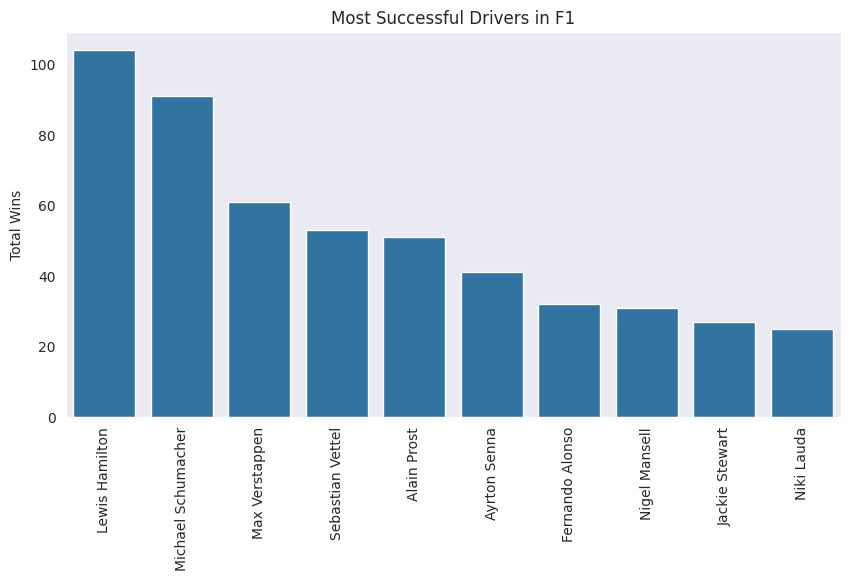

In [7]:
#load the required sheets: drivers and results
#results already loaded in the previous cell
drivers = pd.read_csv('/content/drivers.csv')

query = """
SELECT drivers.forename || " " || drivers.surname AS driver_name,
       COUNT(CASE WHEN results.positionOrder = 1 THEN 1 END) AS total_wins,
       COUNT(CASE WHEN results.positionOrder = 2 THEN 1 END) AS total_second_place,
       COUNT(CASE WHEN results.positionOrder = 3 THEN 1 END) AS total_third_place,
       COUNT(CASE WHEN results.positionOrder IN (2,3) THEN 1 END) AS total_podiums
FROM drivers
JOIN results ON
     drivers.driverId = results.driverId
GROUP BY driver_name
ORDER BY total_wins DESC
LIMIT 10;
"""

result =sqldf.run(query)

#plot
fig,ax=plt.subplots(figsize=(10,5))
sns.set_style('darkgrid')
ax.grid(False)
sns.barplot(data=result, x='driver_name', y='total_wins',ax=ax);
ax.set_title('Most Successful Drivers in F1');
ax.set_xlabel(''); #leaving it blank for aesthetics
ax.set_ylabel('Total Wins');
ax.set_xticklabels(result['driver_name'],rotation=90);